In [39]:
import napari
from napari.utils import nbscreenshot
import logging
logging.getLogger('tifffile').setLevel(logging.ERROR)

%gui qt

# napari

napari is a python image viewer that can display multidimensional arrays.
Here we read directly from a couple tiff files

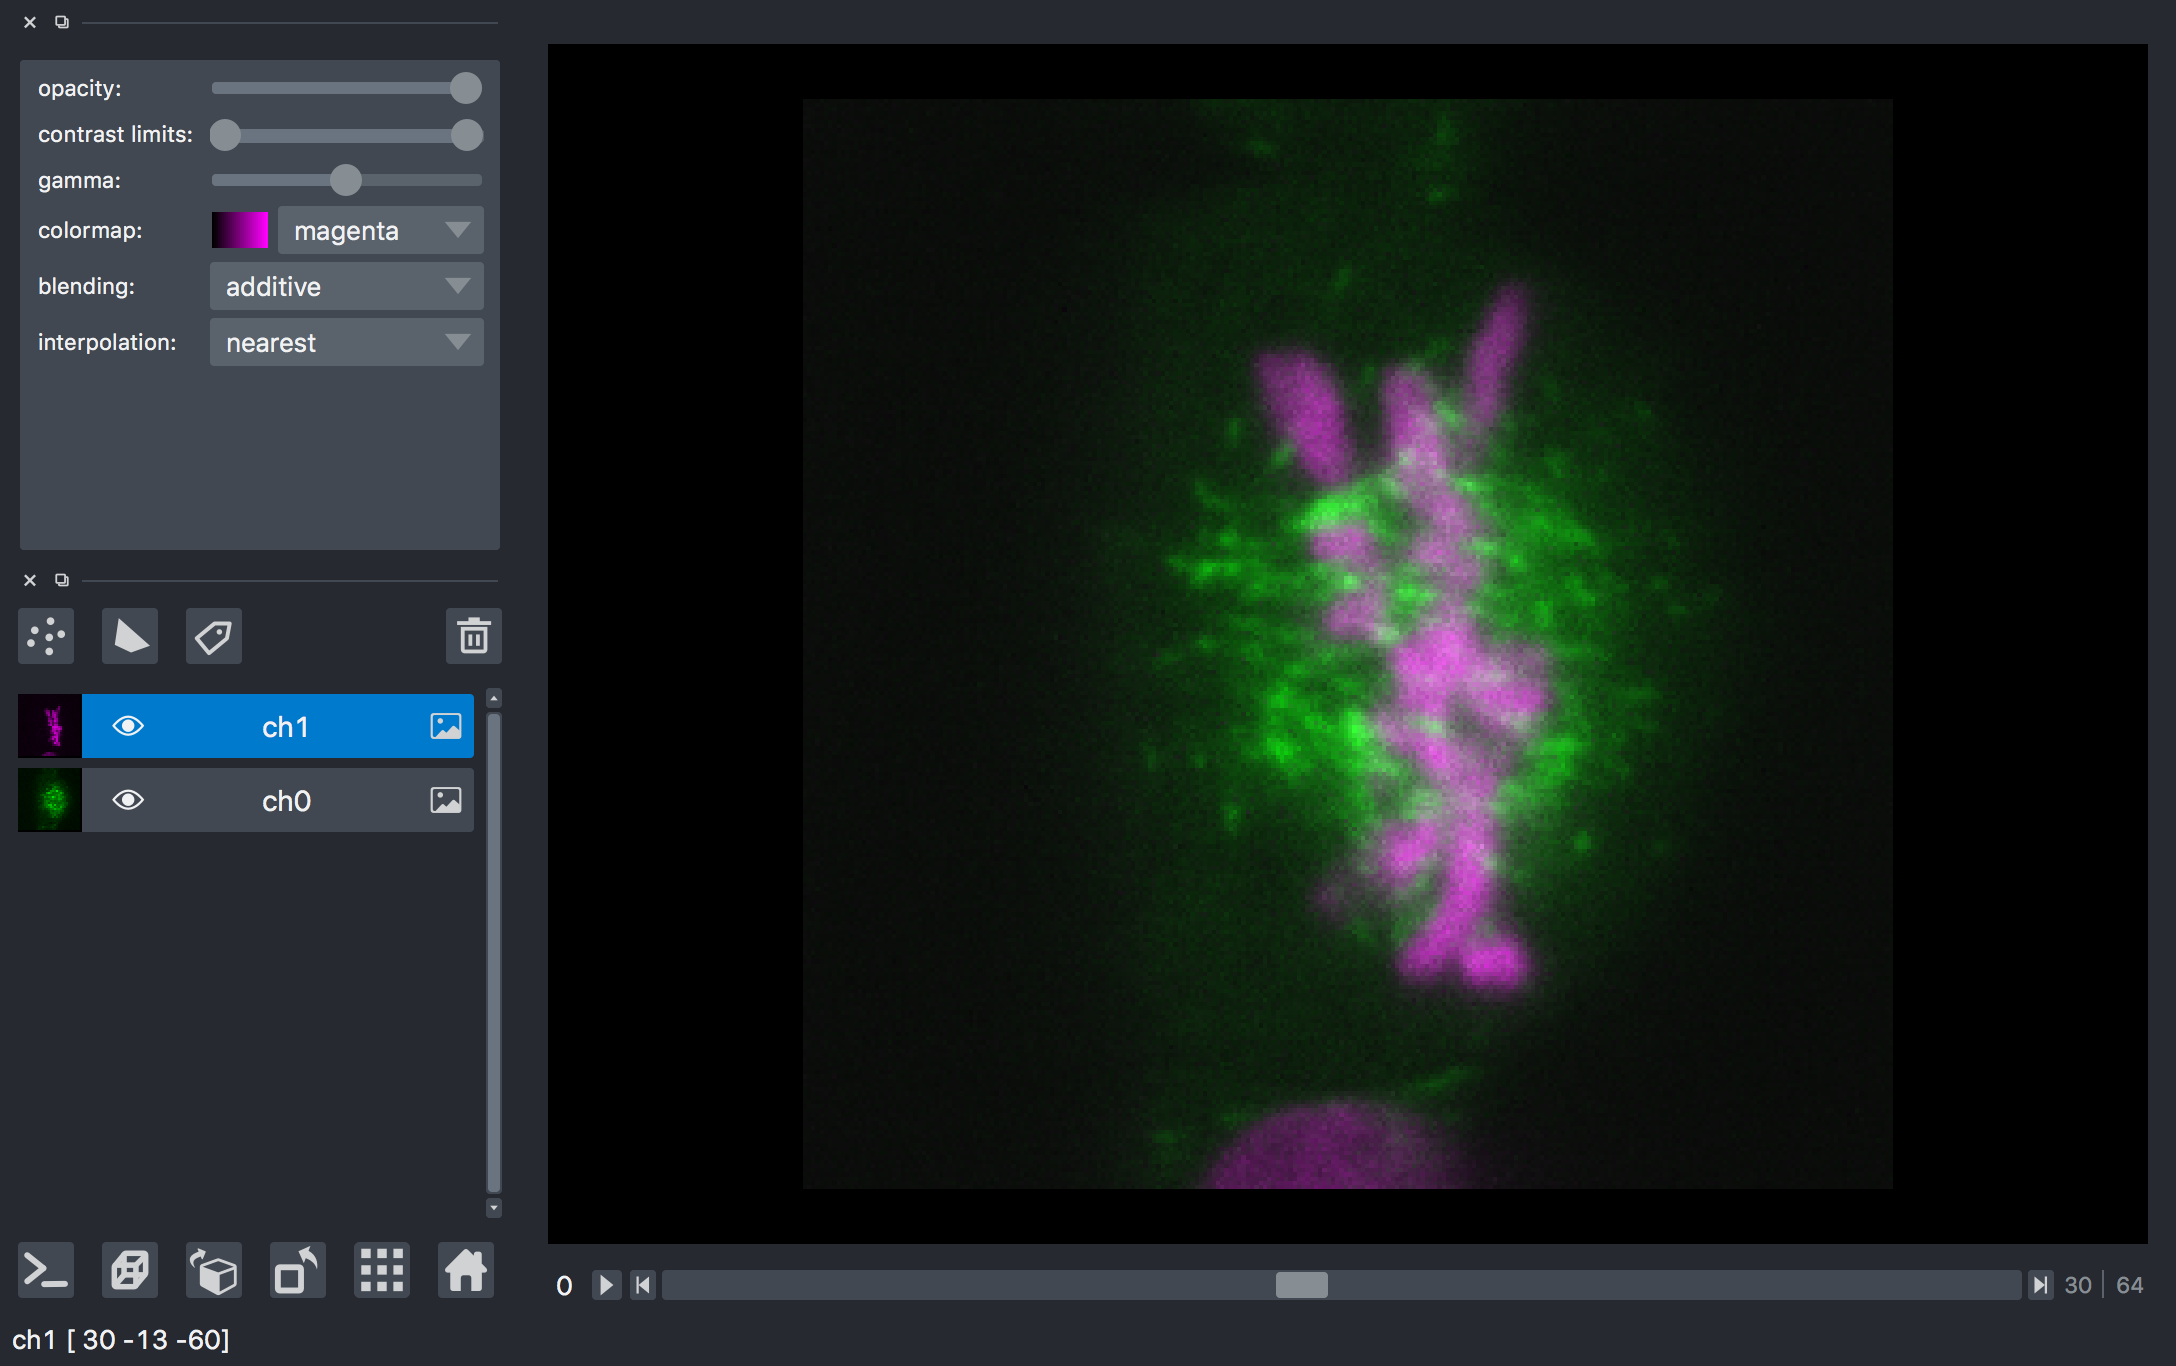

In [6]:
viewer = napari.Viewer(show=False)
viewer.open('ch0.tif', blending='additive', colormap='green')
viewer.open('ch1.tif', blending='additive', colormap='magenta')
viewer.dims.set_point(0, 30)
nbscreenshot(viewer)

## viewing a plain numpy array with napari

like most image viewers, napari accepts multidimensional numpy arrays. 

<class 'numpy.ndarray'> (65, 256, 256) uint16


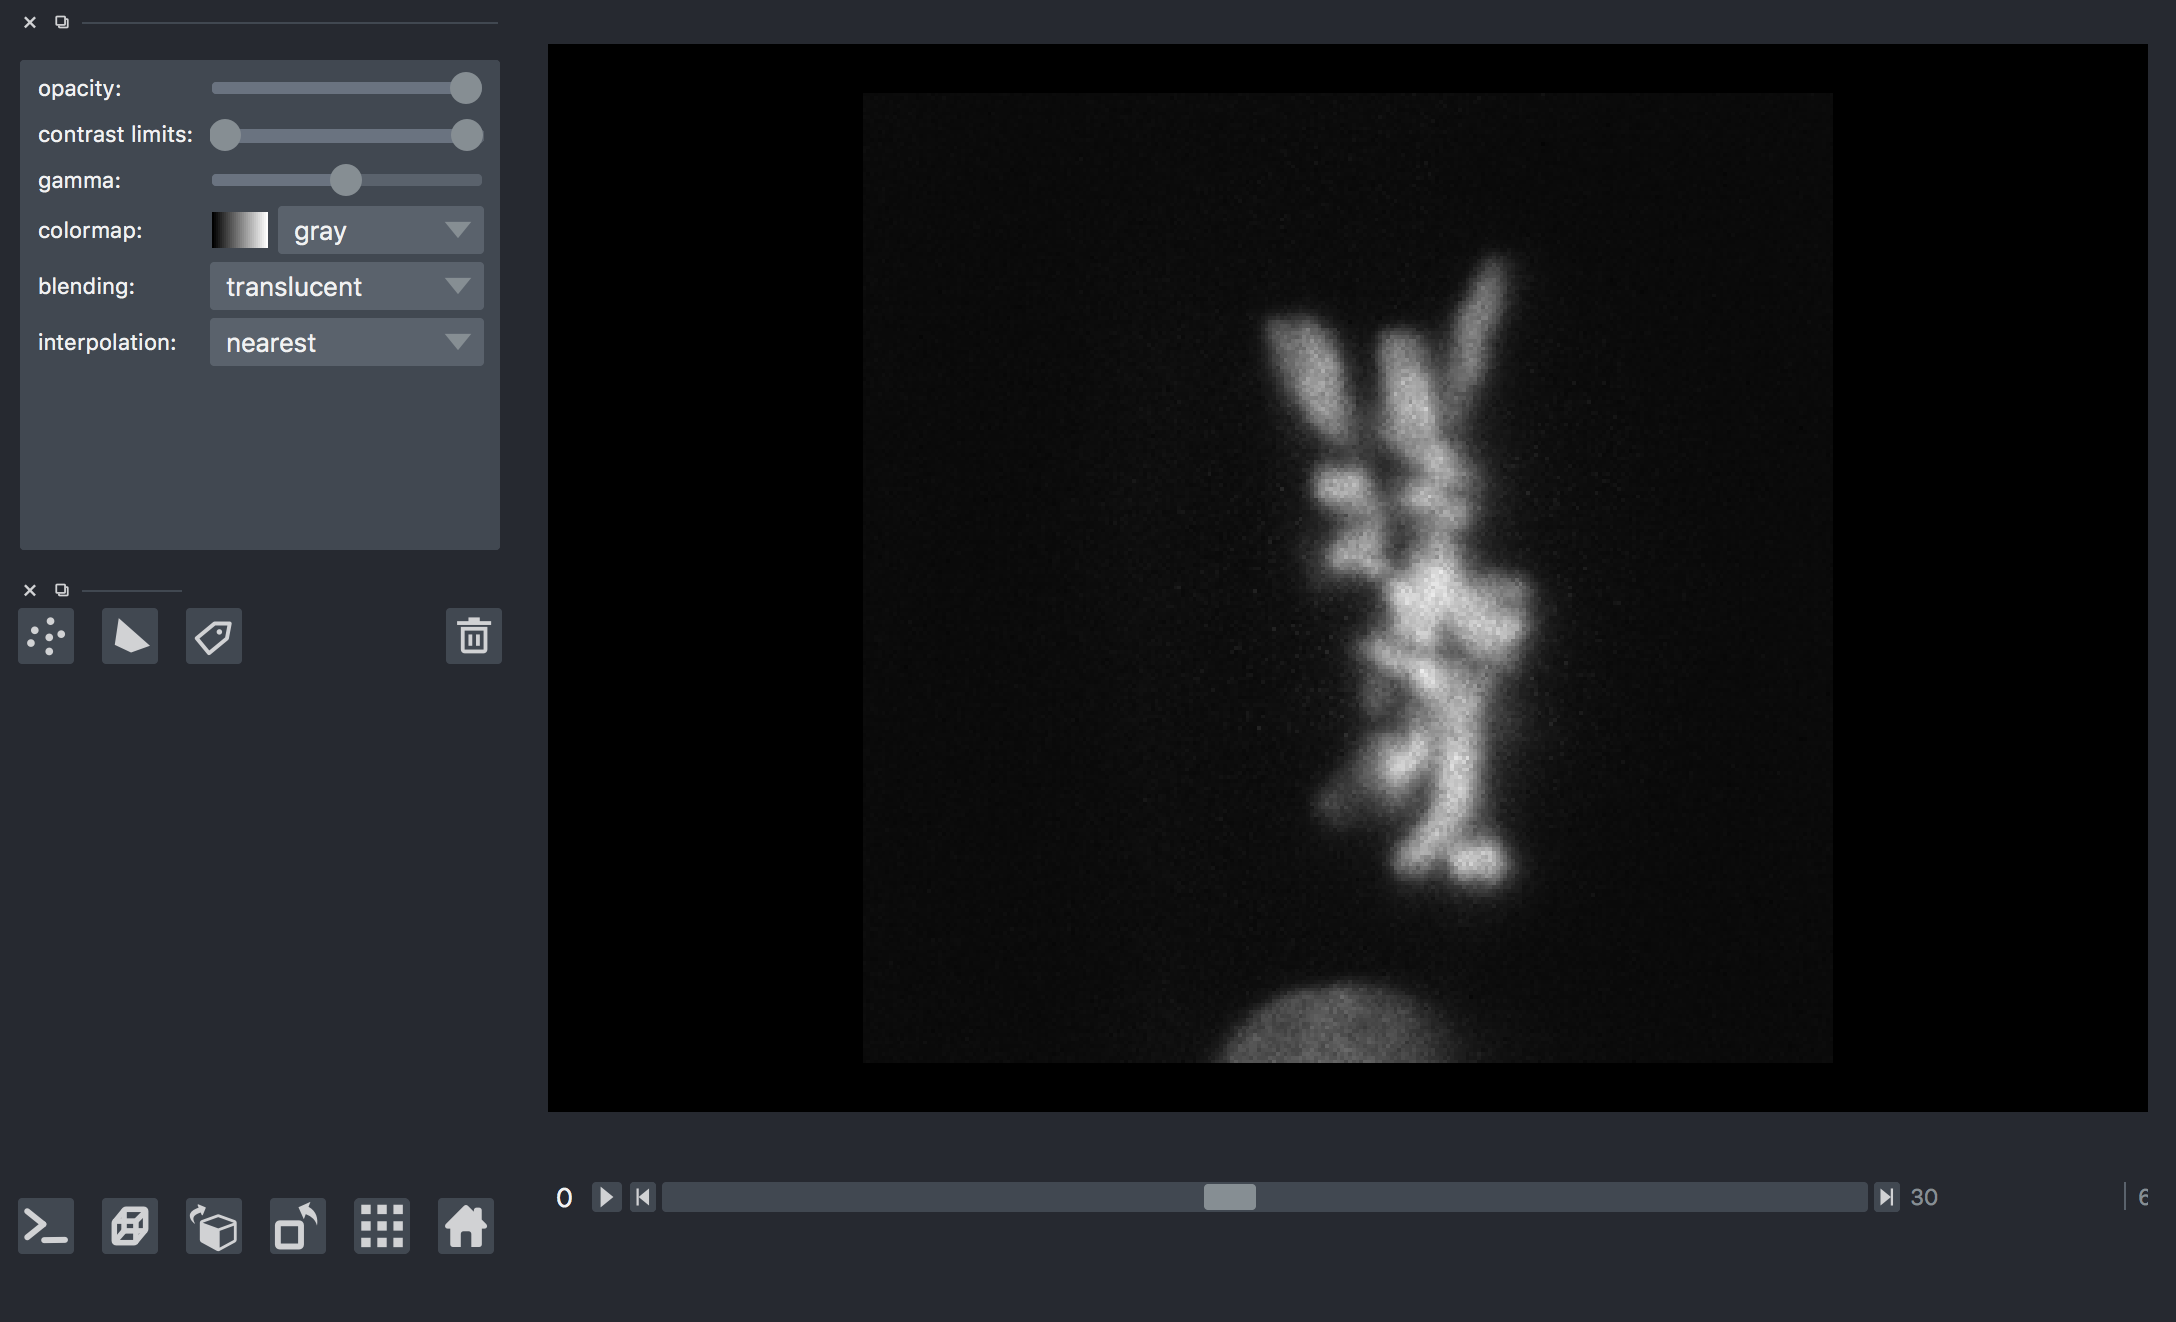

In [7]:
from skimage.io import imread

stack = imread('ch1.tif')
print(type(stack), stack.shape, stack.dtype)

viewer = napari.view_image(stack)
viewer.dims.set_point(0, 30)
nbscreenshot(viewer)

## this image needs some preprocessing before viewing

these images were taken on a stage-scanning light sheet microscope, which acquires raw 3D data in a "skewed" (sheared) coordinate space relative to the "real world".  See video below if you're curious: 

In [12]:
from IPython.display import Video
Video('https://cbmf.hms.harvard.edu/wp-content/uploads/2017/02/deskewing.mp4', width=820)

In any case, like a lot of scientific data, these images need to be preprocessed before we can make sense of them.  In this case, we need to apply an affine transformation:

In [32]:
from pycudadecon import deskew_gpu

deskewed = deskew_gpu(stack, angle=31.5)  # performs a shear transform
viewer = napari.view_image(deskewed, scale=(3, 1, 1), contrast_limits=(100, 1130), show=False)

however, it's also common that you need to chain together a number of pre-processing steps.  Here we deconvolve the result of our shearing operation:

In [33]:
from pycudadecon import decon

psf = imread("ch1_psf.tif")
deconvolved = decon(deskewed, psf=psf)

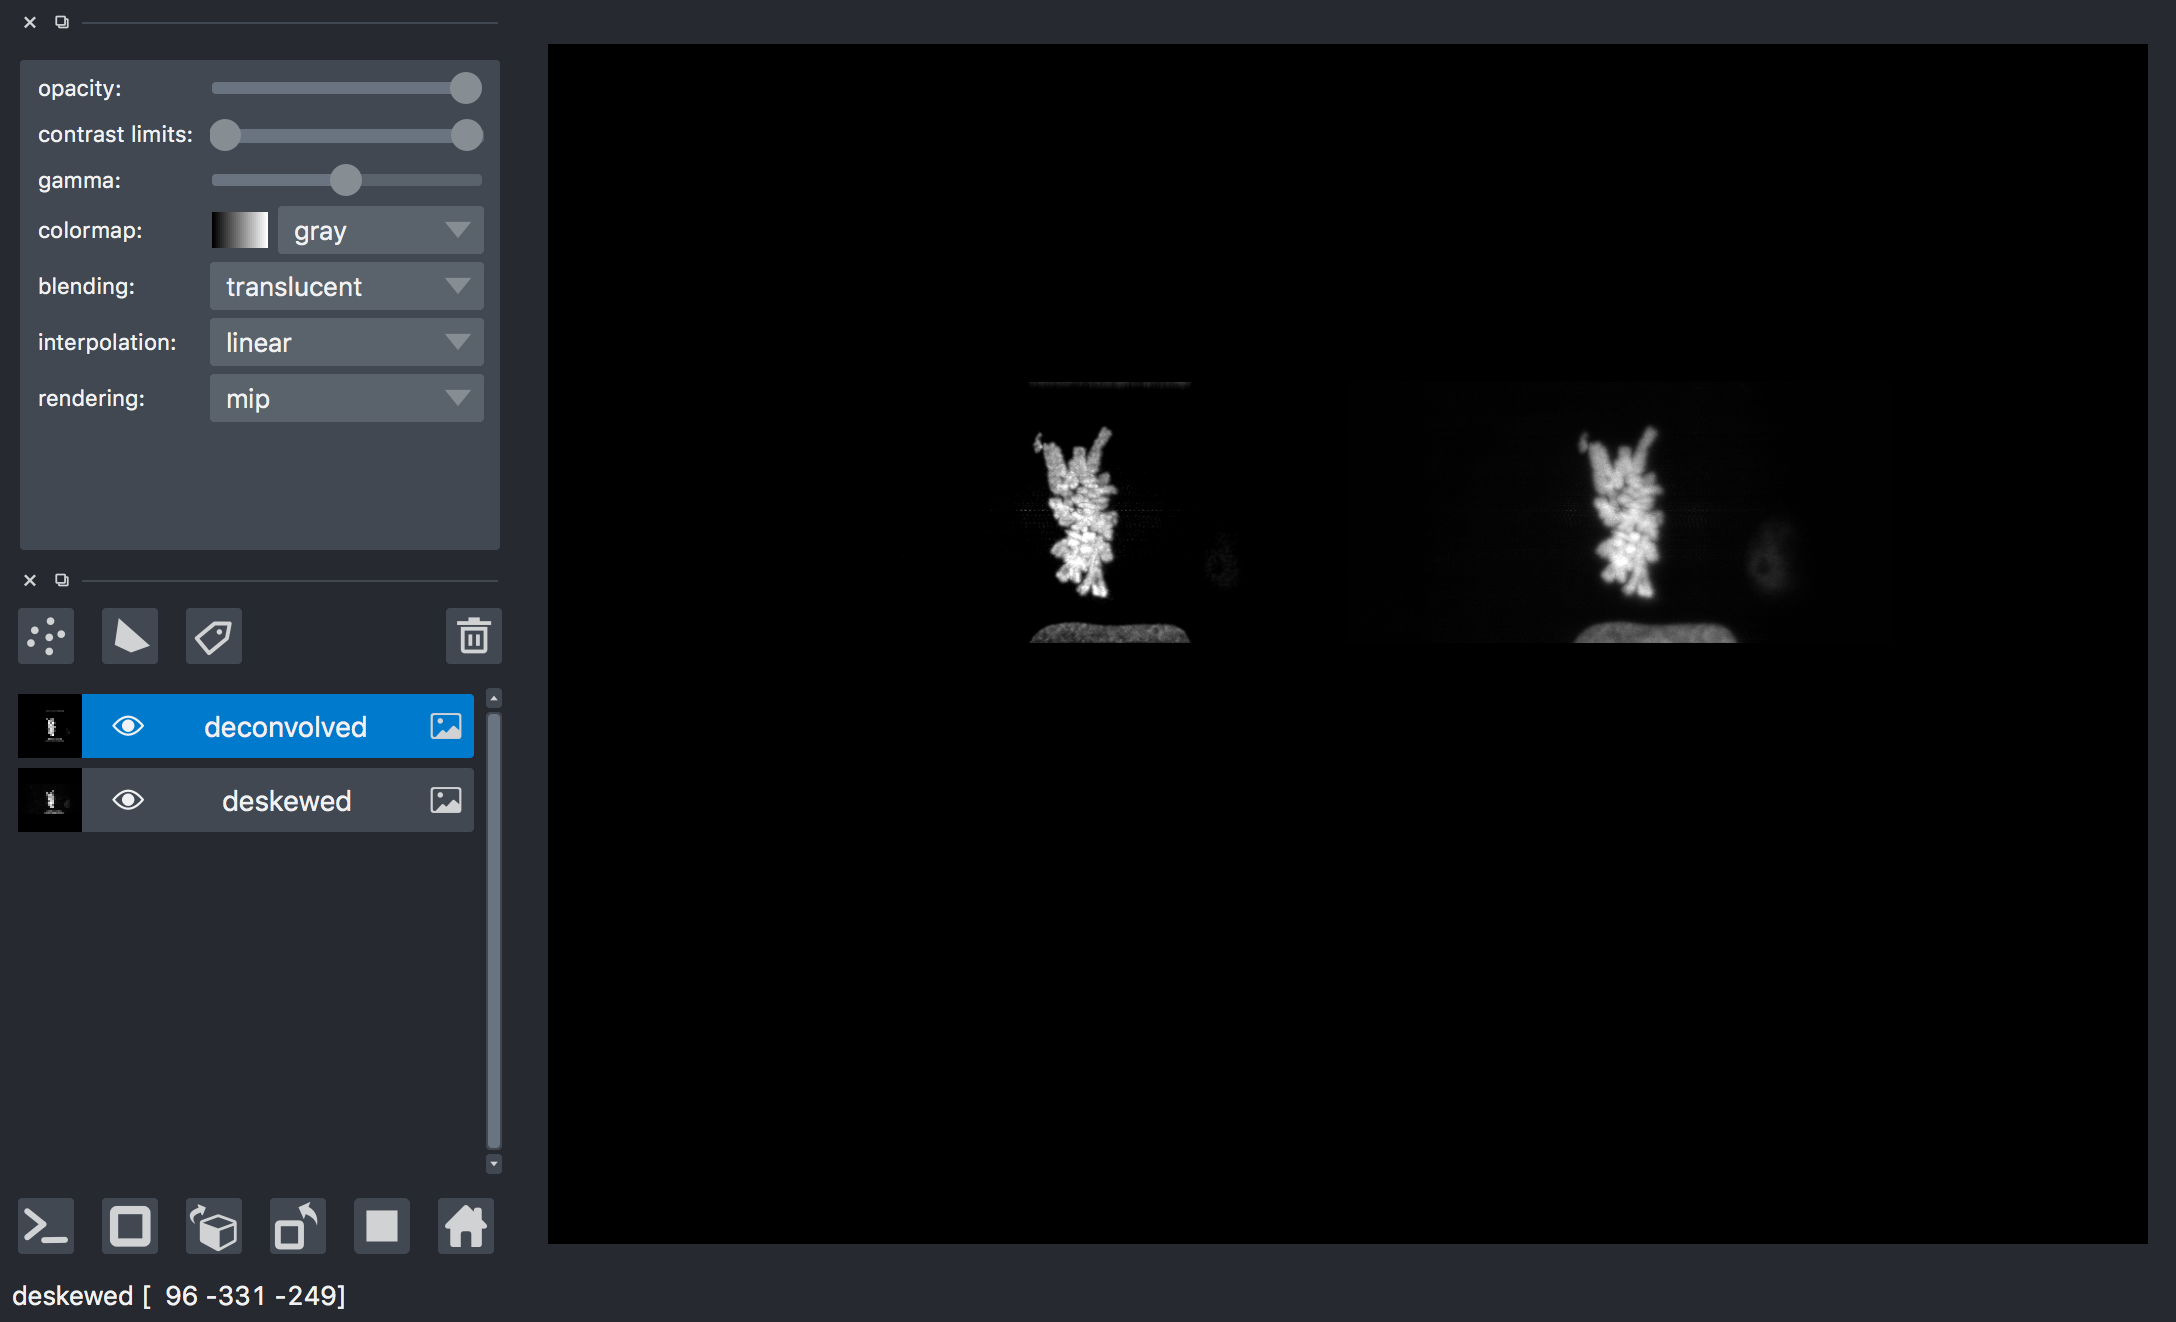

In [34]:
_ = viewer.add_image(deconvolved, scale=(3,1,1), contrast_limits=(100, 1230))
viewer.dims.ndisplay=3
viewer.dims.set_point(0, 30)
viewer.grid_view()
nbscreenshot(viewer)

this is just a single image (with a small field of view) ... but if saved the result of all this preprocessing along with the raw data, it quickly adds up:

In [35]:
print(f"single channel stack is {stack.nbytes/1e6} MB")
print(f"deskewed stack is {deskewed.nbytes/1e6} MB")
print(f"deconvolved stack is {deconvolved.nbytes/1e6} MB")
one_channel_sum = stack.nbytes + deskewed.nbytes + deconvolved.nbytes

# we often have this for multiple channels (e.g. 3) for thousands of timepoints:
total = one_channel_sum * 3 * 1000
print(f"\nthis single cell experiment: ~{total/1e9:.2f} GB (collected in ~30-60 mins)")

single channel stack is 8.51968 MB
deskewed stack is 17.73824 MB
deconvolved stack is 34.4064 MB

this single cell experiment: ~181.99 GB (collected in ~30-60 mins)


and this is a comparatively small dataset for this modality!

## lazy "just-in-time" io

Since this data likely won't fit into local ram, we need a way to load images only upon request...  We can use dask.delayed to convert our skimage.io.imread function into a lazy version.  We then make a dask.array of these lazy arrays.  Napari can then call `.compute()` only on the necessary frames depending on how the user interacts with the dimensions sliders:

In [36]:
from dask.distributed import Client

client=Client()
client

Client Scheduler: tcp://127.0.0.1:61813 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 68.72 GB


In [37]:
from glob import glob

from dask import delayed
import dask.array as da


# list of all files in the dataset
filenames = sorted(glob("/Volumes/extra850/lls_test/*ch1*.tif"))

# open the first file to get shape and dtype
sample = imread(filenames[0])

# create dask stack of lazy image readers
lazy_imread = delayed(imread)  # lazy reader
lazy_arrays = [lazy_imread(fn) for fn in filenames]
dask_arrays = [
    da.from_delayed(lazy_array, shape=sample.shape, dtype=sample.dtype)
    for lazy_array in lazy_arrays
]
# Stack into one large dask.array
dask_stack = da.stack(dask_arrays, axis=0)
dask_stack

,Array,Chunk
Bytes,851.97 MB,8.52 MB
Shape,"(100, 65, 256, 256)","(1, 65, 256, 256)"
Count,300 Tasks,100 Chunks
Type,uint16,numpy.ndarray


In [40]:
# napari accepts dask arrays, and so will only read the file when necessary
viewer = napari.view_image(dask_stack, contrast_limits=[80,1200])

## lazy pre-processing with `dask.map_blocks`

to chain together a sequence of operations (like an affine transformation followed by deconvolution) on our delayed stack, we can use `dask.map_blocks`.  Nothing is actually computed until the data is requested in the napari viewer.

In [41]:
from functools import partial

# prepare some functions that accept a numpy array
# and return a processed array

def last3dims(f):
    # this is just a wrapper because the deconvolution function used here
    # expects ndims==3 but our blocks will have ndim==4
    def func(array):
        extra = array.ndim - 3
        result = f(np.squeeze(array[...,:,:,:]))
        for i in range(extra):
            result = result[None, ...]
        return result
    return func


def crop(array):
    # simple cropping function
    return array[..., 2:, 10:-20, :500]


# https://docs.python.org/3.8/library/functools.html#functools.partial
deskew = last3dims(partial(deskew_gpu, angle=31.5))
deconv = last3dims(partial(decon, psf=psf, background=10))

# map and chain those functions across all dask blocks
deskewed = dask_stack.map_blocks(deskew, dtype="uint16")
deconvolved = deskewed.map_blocks(deconv, dtype="float32")
cropped = deconvolved.map_blocks(crop, dtype="float32")
cropped

,Array,Chunk
Bytes,1.70 GB,17.04 MB
Shape,"(100, 65, 256, 256)","(1, 65, 256, 256)"
Count,600 Tasks,100 Chunks
Type,float32,numpy.ndarray


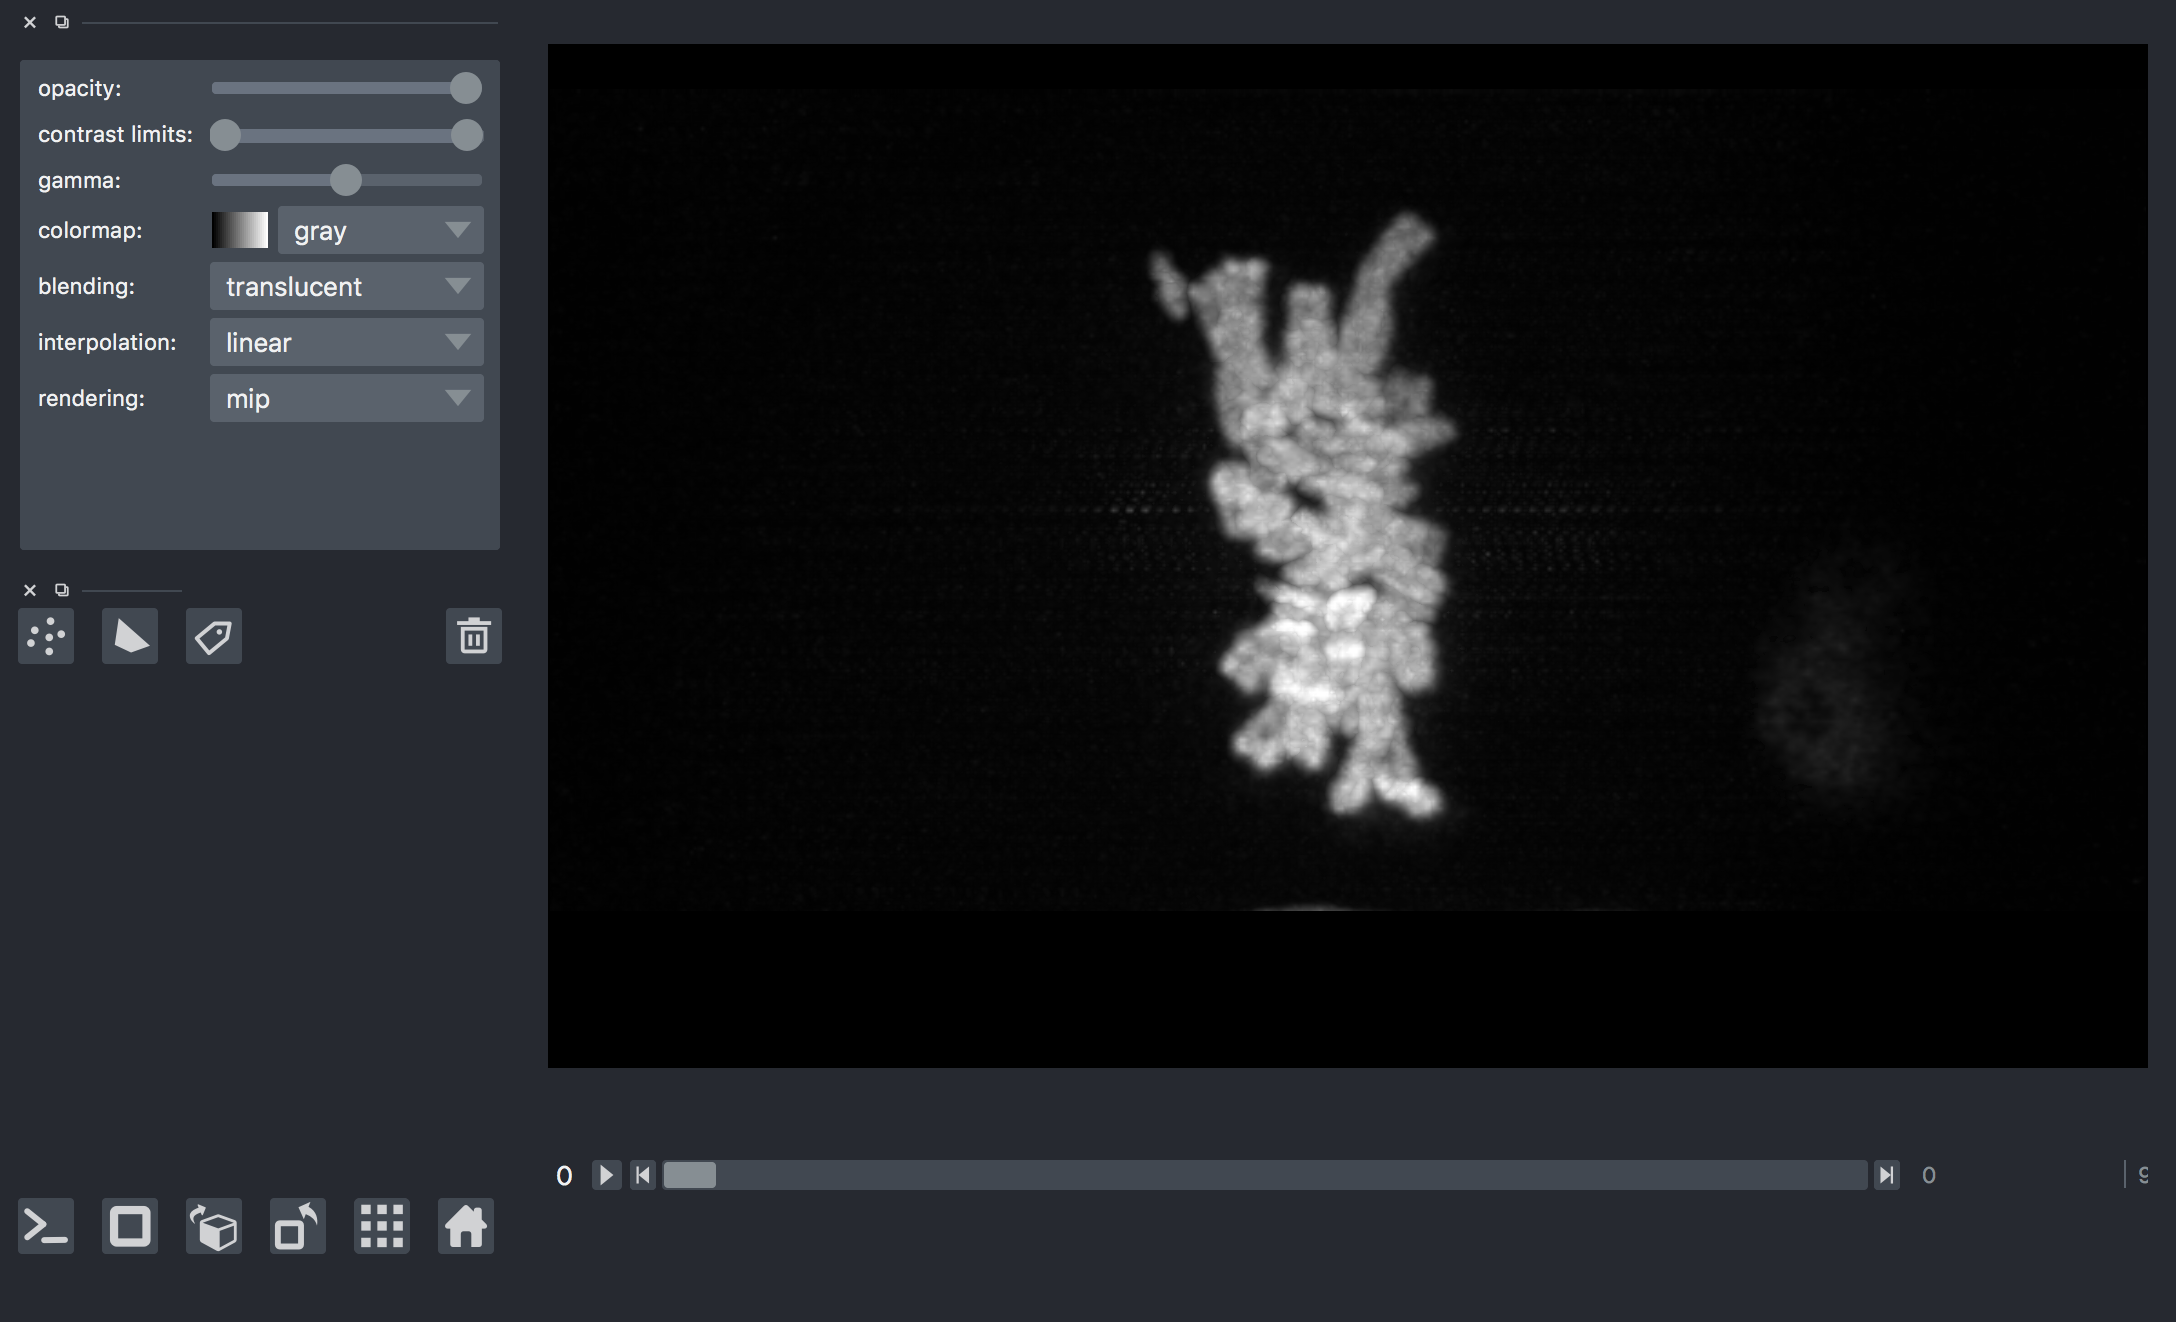

In [43]:
viewer = napari.view_image(
    cropped,
    contrast_limits=[90, 1500],
    multiscale=False,
    ndisplay=3,
    scale=(1, 3, 1, 1),
    translate=(0, 0, 0, -150)
)
nbscreenshot(viewer)

## using dask-image

`dask-image` (https://github.com/dask/dask-image) is a great package that provides a convenient `imread` function that more or less does what we just did above... plus a lot of other delayed image processing goodness

In [44]:
import dask_image.imread

file_pattern = "/Volumes/extra850/lls_test/*ch{}*.tif"
channels = [dask_image.imread.imread(file_pattern.format(i)) for i in range(2)]
dask_stack2 = da.stack(channels)
dask_stack2


,Array,Chunk
Bytes,1.70 GB,8.52 MB
Shape,"(2, 100, 65, 256, 256)","(1, 1, 65, 256, 256)"
Count,800 Tasks,200 Chunks
Type,uint16,numpy.ndarray


In [45]:
# https://docs.python.org/3.8/library/functools.html#functools.partial
deskew = last3dims(partial(deskew_gpu, angle=31.5))
deconv = last3dims(partial(decon, psf=psf, iterations=10, background=10))

# map and chain those functions across all dask blocks
deskewed = dask_stack2.map_blocks(deskew, dtype="uint16")
deconvolved = deskewed.map_blocks(deconv, dtype="float32")
cropped = deconvolved.map_blocks(crop, dtype="float32")
cropped

,Array,Chunk
Bytes,3.41 GB,17.04 MB
Shape,"(2, 100, 65, 256, 256)","(1, 1, 65, 256, 256)"
Count,1400 Tasks,200 Chunks
Type,float32,numpy.ndarray


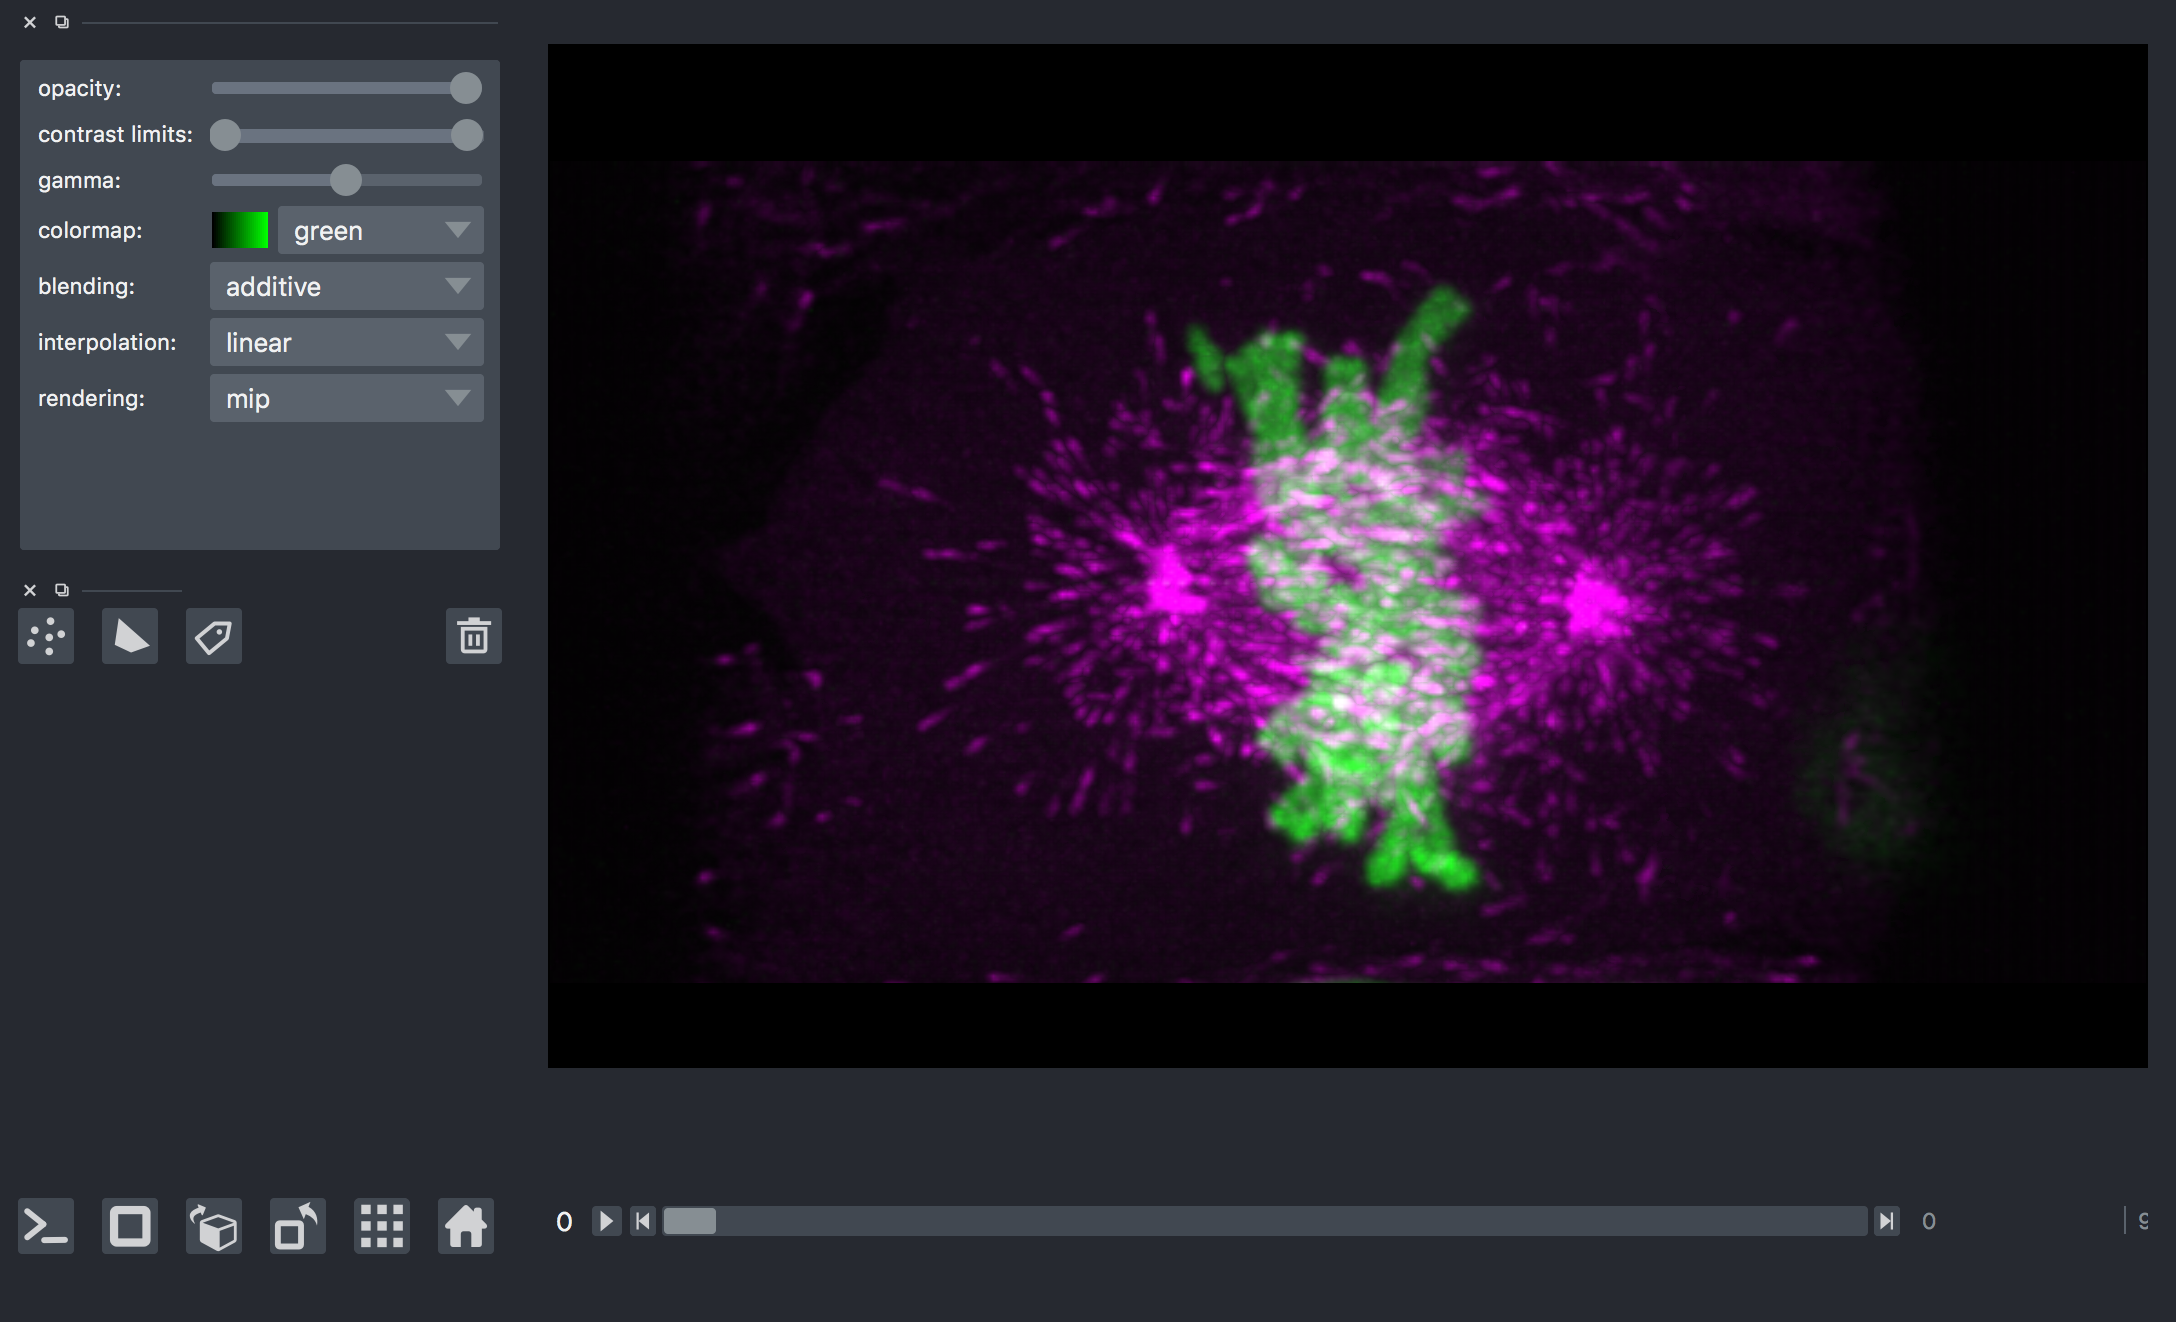

In [47]:
viewer = napari.view_image(
    cropped,
    channel_axis=0,
    contrast_limits=[90, 1500],
    scale=(1,3,1,1),
    translate=(0,0,20,-140)
)
viewer.dims.ndisplay = 3
nbscreenshot(viewer)

It's relatively easy to wrap this sort of dask functionality in a napari plugin, to enable napari to recognize, handle, & process arbitrary custom datatypes and pipelines.  For an example of a plugin that does the above processing (but without deconvolution), see `napari-ndtiffs`: https://github.com/tlambert03/napari-ndtiffs